In [1]:
# -*- coding:utf8 -*-
import json, sys, csv, math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
class GraphConfig:
    def __init__(self, config:dict):
        self.FileName = config['output_file_name']
        self.Dpi = config['dpi']
        self.Width = config['graph_width']
        self.Height = config['graph_height']
        self.MinPeriod = config['min_period']
        self.MaxPeriod = config['max_period']
        self.MinVel = config['min_vel']
        self.MaxVel = config['max_vel']
        self.XLabel = config['x_label']
        self.YLabel = config['y_label']
        self.AccLabel = config['acc_label']
        self.DispLabel = config['disp_label']
        self.EigenPeriod = config['eigen_period']


In [3]:
class Spectrum:
    def __init__(self, item):
        self.Name = item['name']
        self.Path = item['path']
        self.SkipRow = item['skip_row']
        self.PeriodCol = item['period_col'] - 1
        self.SpectrumCol = item['spectrum_col'] - 1
        self.Color = item['color']
        

In [4]:
def graph_init():
    fig = plt.figure(figsize=(graph.Width, graph.Height))
    ax = fig.add_subplot(1,1,1)
    plt.subplots_adjust(left=0.15)
    return fig, ax




In [5]:
def graph_format(ax):
    ax.set_xlim(graph.MinPeriod, graph.MaxPeriod)
    ax.set_ylim(graph.MinVel, graph.MaxVel)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(which="both")
    ax.legend()
    ax.get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.2f'))
    ax.get_yaxis().set_major_formatter(plt.FormatStrFormatter('%.0f'))
    ax.set_xlabel(graph.XLabel)
    ax.set_ylabel(graph.YLabel)



In [6]:
def read_config(path:str):
    with open(path) as f:
        config = json.load(f)
    return config



In [7]:
def read_vel_resp_spectrum(path:str, skip_row:int, period_col:int, spectrum_col:int):
    df = pd.read_csv(path, header=None, skiprows=skip_row)
    return df[period_col].values, df[spectrum_col].values



In [8]:
def get_grid_lines_of_acc_and_disp():
    x1 = graph.MinPeriod
    x2 = graph.MaxPeriod
    # acc
    acc_list = np.concatenate([np.linspace(int(10**i), int(10**(i+1)), 10) for i in range(4)])
    acc_lines = {}
    for acc in acc_list:
        # Sv = Sa / (2π/T)
        y1 = acc / (2.0 * np.pi / x1)
        y2 = acc / (2.0 * np.pi / x2)
        acc_lines[acc] = [x1, x2, y1, y2]
    # disp
    disp_list = np.concatenate([np.linspace(int(0.01*10**i), int(0.01*10**(i+1)), 10) for i in range(4)])
    disp_lines = {}
    for disp in disp_list:
        # Sv = Sd * (2π/T)
        y1 = disp * (2.0 * np.pi / x1)
        y2 = disp * (2.0 * np.pi / x2)
        disp_lines[disp] = [x1, x2, y1, y2]
    return acc_lines, disp_lines



In [9]:
def draw_grid(grid_type, fig, ax, label, lines, text_pos, angle, vertalalign):
    for k, v in lines.items():
        x1, x2, y1, y2 = tuple(v)
        ax.plot([x1, x2], [y1, y2], color='darkgray', linewidth='0.5')
        text = '{:.0f}'.format(k)
        if (grid_type == 'acc'):
            if (np.log10(k)).is_integer():
                ax.text(x1, y1, text, rotation=angle, verticalalignment=vertalalign)
        elif (grid_type == 'disp'):
            if k >= 1.0 and (np.log10(k)).is_integer():
                ax.text(x2, y2, text, rotation=angle, verticalalignment=vertalalign)
    fig.text(text_pos[0], text_pos[1], label, rotation=angle)



In [10]:
def draw_grids(fig, ax):
    acc_lines, disp_lines = get_grid_lines_of_acc_and_disp()
    draw_grid('acc', fig, ax, graph.AccLabel, acc_lines, [0.3, 0.65], 45, 'bottom')
    draw_grid('disp', fig, ax, graph.DispLabel, disp_lines, [0.7, 0.75], -45, 'top')



In [11]:
def draw_vel_spectrum(ax):
    for spec in spectra:
        x, y = read_vel_resp_spectrum(spec.Path, spec.SkipRow, spec.PeriodCol, spec.SpectrumCol)
        ax.plot(x, y, label=spec.Name, color=spec.Color)



In [12]:
def draw_period_line(ax):
    for period in graph.EigenPeriod:
        ax.plot([period, period], [graph.MinVel, graph.MaxVel], color='black', linestyle='dashed')



In [13]:
def draw_tripartite():
    fig, ax = graph_init()
    draw_grids(fig, ax)
    draw_vel_spectrum(ax)
    draw_period_line(ax)
    graph_format(ax)
    plt.savefig(graph.FileName, dpi=graph.Dpi)
    plt.show()



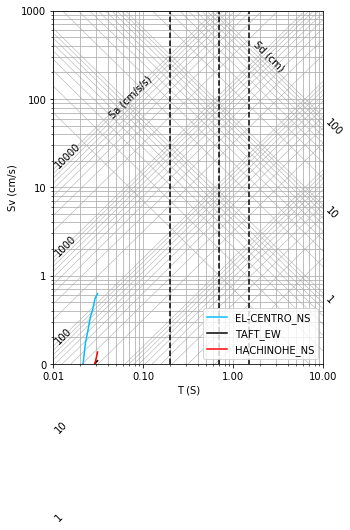

In [14]:
if __name__ == '__main__':
    config = read_config('./config.json')
    graph = GraphConfig(config['graph'])
    spectra = []
    for item in config['spectra']:
        spectra.append(Spectrum(item))
    draw_tripartite()
